# «Культурист-датасаентист» разработка взаимодействия с пользователями на основе аналитических данных

Проведем работу для Сети фитнес-центров «Культурист-датасаентист» по направлению изучения оттока пользователей, а также кластеризуем клиентов и дадим рекомендации

### Оглавление
1. [Шаг 1. Загрузка данных и библиотек](#1_id)
2. [Шаг 2. Проведем исследовательский анализ данных (EDA)](#2_id)
3. [Шаг 3. Построим модель прогнозирования оттока пользователей](#3_id)
4. [Шаг 4. Кластеризация пользователей](#4_id)
5. [Шаг 5. Сформулируем выводы и сделаем базовые рекомендации по работе с клиентами](#5_id)


## Шаг 1. Загрузка данных и библиотек <a id="1_id"></a>

Загрузим необходимые библиотеки

In [299]:
import pandas as pd
from matplotlib import pyplot as plt
from plotly import graph_objects as go
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score 
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')   

Загрузим датасет

In [300]:
data = pd.read_csv('/datasets/gym_churn.csv')

Прочитаем первые 10 строк

In [301]:
data.head(10)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


Посмотрим info

In [302]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


Пропусков нет, данные приведены к нужным типам, единственное что смущает - заглавные буквы в наименованиях колонок

In [303]:
data.columns = data.columns.str.lower()

Отлично, загрузили данные, проверили на ошибки, изменили наименование заголовков, переходим к шагу 2.

## Шаг 2. Проведем исследовательский анализ данных (EDA) <a id="2_id"></a>

#### Посмотрим на датасет: есть ли в нем отсутствующие признаки, изучим средние значения и стандартные отклонения

In [304]:
data.describe().style.set_precision(5)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000
mean,0.51025,0.84525,0.48675,0.3085,0.9035,4.6813,0.41225,29.184,146.94,4.3228,3.7247,1.879,1.7671,0.26525
std,0.49996,0.36171,0.49989,0.46193,0.29531,4.5497,0.4923,3.2584,96.356,4.1913,3.7493,0.97224,1.0529,0.44152
min,0,0,0,0,0,1,0,18,0.1482,1,0,0,0,0
25%,0,1,0,0,1,1,0,27,68.869,1,1,1.1809,0.963,0
50%,1,1,0,0,1,1,0,29,136.22,1,3,1.8328,1.7196,0
75%,1,1,1,1,1,6,1,31,210.95,6,5,2.5361,2.5103,1
max,1,1,1,1,1,12,1,41,552.59,12,31,6.0237,6.1468,1


Так, пол 1 или 0, среднее значение  0,51 (ну в целом понятно), отклонение 0,5 (или к 1 или к 0), что тоже логично
Далее расположенность по близости, среднее значение 0,85 (85% находится поблизости от фитнеса), отклонение 0,36.
Работодатель партнер 0,49 среднее, отклонение 0,5. Половина клиентов имеют работодателей партнеров, отсюда и отклонение 0,5.
Промо для друзей 0,30, отклонение 0,46. Уже встречается пореже чем скидки для партнеров работодателей
Наличие телефона 0,90, чтобы его не предоставить? =) отклонение 0,30.
Период текущего действующего абонемента средний 4,68, отклонение 4,55. 
Групповые занятия - 0,41 среднее значение, 0,49 отклонение. 
Возраст средний - 29,18, отклонение - 3,25
Суммарная выручка от дополнительных услуг среднее значение - 146,94, отклонение 96,356
Кол-во месяцев до окончания абонемента, среднее значение - 4,32, среднее отклонение 4,19
Время с первого обращения в фитнесс, среднее значение 3,72, отклонение 3,75
Средняя частота посещений в неделю 1,88, отклонение 0,97
Средняя частота посещений в неделю за последний месяц 1,77, отклонение 1,05 (интересная метрика так как у нас тут те клиенты которые совершили отток, интересно посмотреть как сократилось среднее посещение)
Ну и сам отток собственно - 0,26 среднее 0,44 отклонение

Пропусков нет. Едем дальше

#### Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался


In [305]:
comparison = data.groupby('churn').agg('mean').reset_index()
comparison.style.set_precision(3)

,churn,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,0,0.51,0.873,0.534,0.354,0.904,5.75,0.464,30,158,5.28,4.71,2.02,2.03
1,1,0.511,0.768,0.355,0.184,0.903,1.73,0.269,27,115,1.66,0.991,1.47,1.04


Сравним две группы, пол вроде тот же. Далее удаленность, те кто ушли чаще находились не по близости (в целом на это повлиять нет возможности клиентам было неудобно, только расширять сеть), те кто ушли чаще не имели скидок от работодателей партнеров (а вот тут мы можем повлиять, машина научиться предвидеть отток, а мы им скидочку на следующие абонементы). Промо от друзей у тех кто ушел ниже чем у тех кто остался (по аналогии со скидкой от работодателя можно поступать), показатель наличия телефона одинаков (инструмент для взаимодействия в целом неплохой смс рассылка, звонок), период абонемента который приобретается среди тех кто ушел сильно ниже тех кто остался (про скидки для отточной группы мы в курсе, быть может проблема в том, что дорого брать на подольше?), групповые занятия - клиенты которые покинули нас реже ходят на групповые занятия (быть может тут психологический эффект когда один занимаешься желание пропадает? спорно конечно, не путаю ли я причину со следствием? но факт остается фактом). Дальше у нас возраст, тоже интересные наблюдения. Средний возраст оттока ощутимо меньше среднего возраста тех, кто остался. Плата за доп услуги у оттока также ниже, достаточно сильно ниже (тоже может служить индикатором). Месяцев до окончания контракта у группы оттока - сильно ниже 1,66 (против 5,28 у второй). Дальше у нас лайфтайм. У группы отток 0,991, у второй группы 4,7. Говорит о том, что клиенты часто берут 1 месяц и не продлевают его (также вспомним что средний контракт период у группы отток 1,73).  Среднее посещение зала в целом у оттока 1,47 в неделю, у второй группы 2. Среднее посещение в текущем месяце у оттока 1,04, у второй группы 2,03. В сравнении 2 х последних метрик видно, как падает средне недельная посещаемость.

#### Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);

Немного почитали и посравнивали данные, теперь можно построить и полноценные графики

In [306]:
comparison.columns = ['Отток', 'Пол', 'Близкое расположение', 'Работодатель-партнер', 
                      'Промо друга', 'Телефон', 'Период контракта', 'групповые занятия', 
                      'Возраст', 'Выручка по доп услугам', 'Месяцев до окончания контракта', 
                      'Месяцев с 1го обращения', 'Средненедельное посещение', 'Средненедельное посещение за текущий месяц']
comparison['Отток'] = comparison['Отток'].replace(0, 'Не отток')
comparison['Отток'] = comparison['Отток'].replace(1, 'Отток')
comparison

,Отток,Пол,Близкое расположение,Работодатель-партнер,Промо друга,Телефон,Период контракта,групповые занятия,Возраст,Выручка по доп услугам,Месяцев до окончания контракта,Месяцев с 1го обращения,Средненедельное посещение,Средненедельное посещение за текущий месяц
0,Не отток,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,Отток,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


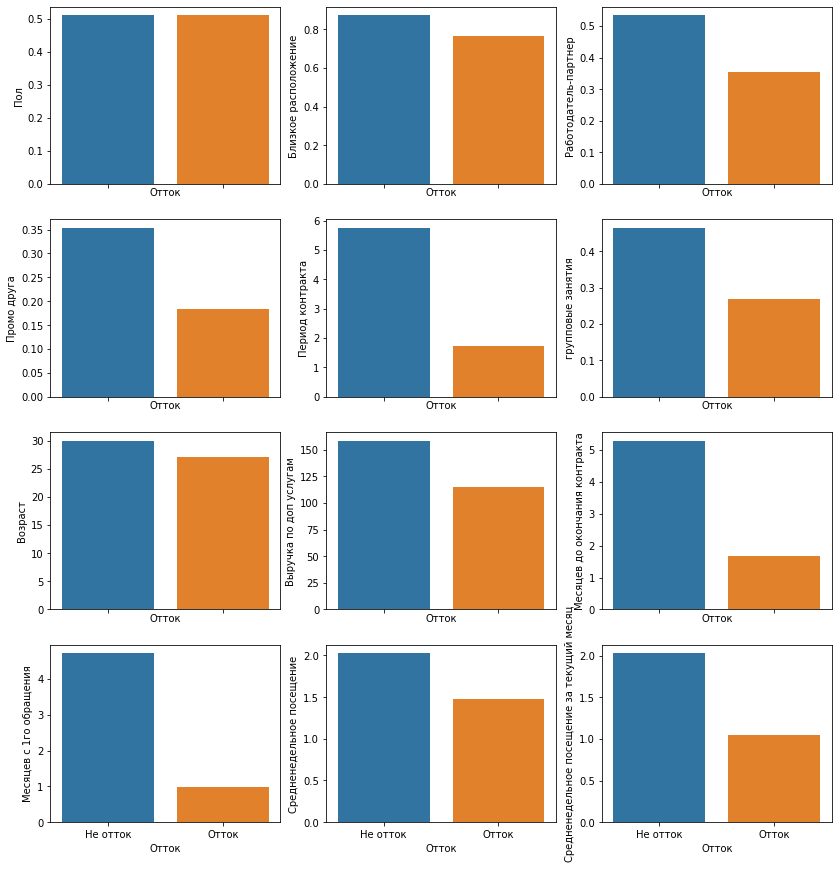

In [307]:
f, axes = plt.subplots(4, 3, figsize=(14, 15), sharex=True)
sns.barplot(x="Отток", y='Пол', data=comparison, ax=axes[0, 0]) 
sns.barplot(x="Отток", y='Близкое расположение', data=comparison, ax=axes[0, 1]) 
sns.barplot(x="Отток", y='Работодатель-партнер', data=comparison, ax=axes[0, 2]) 
sns.barplot(x="Отток", y='Промо друга', data=comparison, ax=axes[1, 0]) 
sns.barplot(x="Отток", y='Период контракта', data=comparison, ax=axes[1, 1]) 
sns.barplot(x="Отток", y='групповые занятия', data=comparison, ax=axes[1, 2]) 
sns.barplot(x="Отток", y='Возраст', data=comparison, ax=axes[2, 0]) 
sns.barplot(x="Отток", y='Выручка по доп услугам', data=comparison, ax=axes[2, 1]) 
sns.barplot(x="Отток", y='Месяцев до окончания контракта', data=comparison, ax=axes[2, 2]) 
sns.barplot(x="Отток", y='Месяцев с 1го обращения', data=comparison, ax=axes[3, 0]) 
sns.barplot(x="Отток", y='Средненедельное посещение', data=comparison, ax=axes[3, 1]) 
sns.barplot(x="Отток", y='Средненедельное посещение за текущий месяц', data=comparison, ax=axes[3, 2]) 


В текущем формате удобно и наглядно представлена вся информация

#### Построим матрицу корреляций

У нас очень много колонок и когда будем сравнивать их будет нечитаемо, лучше сразу построим тепловую карту

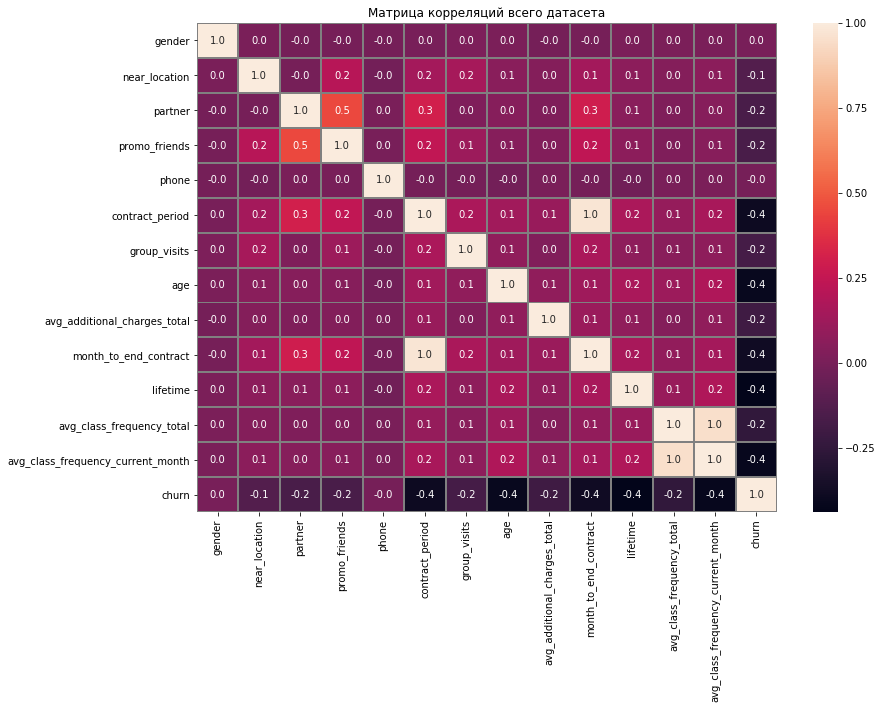

In [308]:
plt.figure(figsize=(13, 9))
plt.title('Матрица корреляций всего датасета')
sns.heatmap(data.corr(), annot=True, fmt='.1f', linewidths=1, linecolor='gray')

Пол и телефон не коррелирует ни с чем. Локации рядом с местами пребывания коррелируют с Промо друзьями, периодом контракта и групповыми занятиями. Партнерка и промо друга хорошо коррелирует (видимо те, кто получает от работы скидки зовут и рекомендуют друзьям). Партнерка и период контракта тоже неплохо, чем дешевле, тем больше берем =). а период и месяцев до окончания между собой коррелируют, так что опосредовано коррелируют и с партнеркой. Промо друга также неплохо влияет с периодом и с сопутствующим периоду сроку до окончания периода подписки. Взаимно чрезмерно коррелируют друг с другом средняя посещаемость и средняя посещаемость в последний месяц. Позже для машинного обучения уберем из датасета Телефон, Пол, Кол-во месяцев контракта (они одинаково коррелируют с месяцами до конца периодом контракта), и среднюю посещаемость за все время (слишком коррелирует с посещаемостью за последний месяц, но хуже с целевым показателем оттока). Вроде остальные в порядке. Идем дальше

## Шаг 3. Построим модель прогнозирования оттока пользователей  <a id="3_id"></a>

Начнем с чистки столбцов. Уберем столбцы, которые не влияют на ситуацию или слишком коррелируют внутри себя

In [309]:
data = data.drop(['gender', 'phone', 'contract_period', 'avg_class_frequency_total'], axis=1)

Добавим цвета

In [310]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   END = '\033[0m'

Покажем где признаки (Х), где целевая переменная, разобьем на тренировочную и тестовую массивы, стандартизируем признаки, перечислим модели, в цикле посмотрим получим прогноз и посмотрим метрики

In [311]:
X = data.drop(columns = ['churn'])
y = data['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.fit_transform(X_test)
models = [LogisticRegression(), RandomForestClassifier(random_state = 1)]
for model_i in models:
    print(model_i)
    model = model_i
    model.fit(X_train_st, y_train)
    y_pred = model.predict(X_test_st)
    print(color.BLUE + 'accuracy', accuracy_score(y_test, y_pred))
    print('precision', precision_score(y_test, y_pred))
    print('recall', recall_score(y_test, y_pred))
    print(color.END)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
accuracy 0.91125
precision 0.8288288288288288
recall 0.847926267281106

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)
accuracy 0.89625
precision 0.8418367346938775
recall 0.7603686635944701



Метрика у логистической регрессии (accuracy) мне нравится больше. 0,91 против 0,90, тут +- одинаковые значения. (но у нас классы не совсем сбалансированы) надо смотреть метрики которые не опираются на соотношения классов. Precision в линейной 0,825, а в Рандоме - 0,86 победитель лес, а вот при проверке recal в линейной 0,847, в рандоме 0,741 разница более значительна. Предпочтение отдается LogisticRegression. Переходим к 4 шагу.

## Шаг 4. Кластеризация пользователей <a id="4_id"></a>


Сделаем дендрограмму. Загрузим нужную библиотеку.

In [312]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

Стандартизируем и передадим функции linkage, которая и выполнит иерархическую кластеризацию. X как раз содержит 

In [313]:
sc = StandardScaler()
x_sc = sc.fit_transform(X)

linked = linkage(x_sc, method = 'ward')

Собственно строим дендрограмму

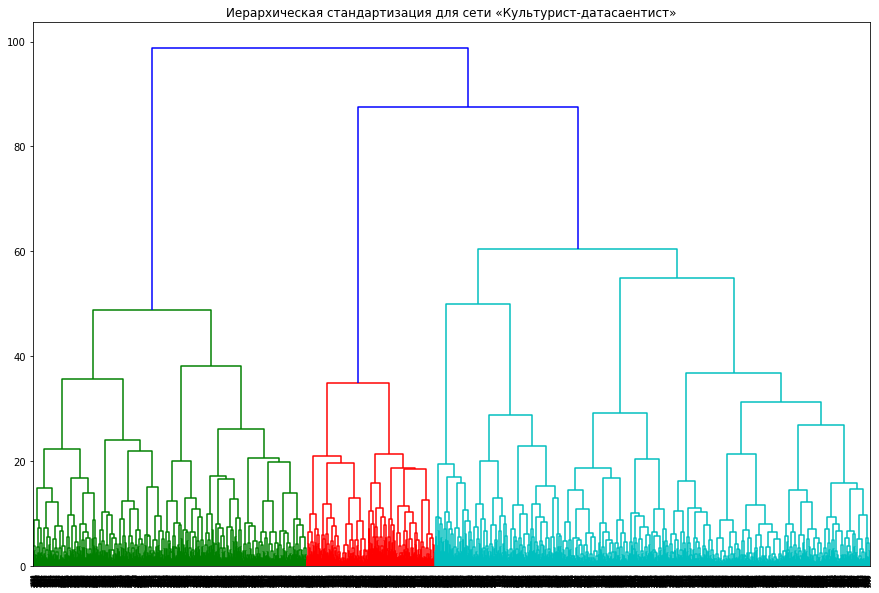

In [314]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая стандартизация для сети «Культурист-датасаентист»')
plt.show()

На дендрограмме 3 кластера, но разобьем на 5 кластеров,зеленый и голубой напрашивается еще поделить

In [315]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

km = KMeans(n_clusters = 5, random_state=0)
labels = km.fit_predict(X_sc)

Присоединим группы к базе

In [316]:
data = data.set_index(labels).reset_index().rename(columns ={'index':'group'})

Посмотрим как распредились клиенты по группам

In [317]:
(data.groupby('group').agg({'near_location':'count'})
 .reset_index().style.bar(subset=['near_location'], align='mid', color=['#B0E0E6']))

,group,near_location
0,0,991
1,1,804
2,2,838
3,3,612
4,4,755


Достаточно равномерно (выбиваются группы 3 и 1). Посмотрим средние значения по кластерам

In [318]:
(data.groupby('group').agg('mean')
 .reset_index()
 .style.bar(subset=['near_location', 'partner', 'promo_friends', 
                    'group_visits', 'age', 'avg_additional_charges_total', 
                    'month_to_end_contract', 'lifetime', 'avg_class_frequency_current_month',
                    'churn'], align='mid', color=['#B0E0E6']).set_precision(5))

,group,near_location,partner,promo_friends,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_current_month,churn
0,0,0.99495,0.95459,1,0.52876,29.658,154.4,6.7629,4.3169,1.9298,0.10394
1,1,1,0.23259,0.12189,0.1791,26.779,110.93,1.709,1.408,0.97925,0.74129
2,2,0.99881,0.27208,0.077566,1,30.243,155.16,4.6921,4.4654,2.033,0.096659
3,3,0,0.4902,0.073529,0.23366,28.694,137.24,2.8399,3.0245,1.5991,0.40196
4,4,0.99868,0.37881,0.046358,0,30.346,174.25,4.6954,5.1603,2.2333,0.046358


Поехали читать данные.
Начнем с локации, что бросается в глаза группа №3 - это клиенты у которые зал не поблизости от места работы или проживания. т.е Группа 3 - клиенты, которые находятся далеко от спортзала (по кол-ву самая малочисленная)
Далее признак работодатель - партнер. В группе №0 почти все клиенты работодатели партнеры самая многочисленная группа.
Далее признак промо друга. В группе №0 все клиенты с промо друга.
Признак групповые занятия. Не так однозначно. Группа номер 2 целиком состоит из клиентов, групповые визиты совершали и группы 3, 0, 1.
Возраст примерно одинаков.
Выручка за дополнительные услуги не одинакова и колеблется от 110 до 174.
Месяцев до окончания абонемента. Тут выделяется Группа №1 и группа №3.
Lifetime тут явно сильно выделяется группа №1. Попробую предположить, что тут новички.
Средненедельное посещение в последнем месяце снова выделяются №1 и №3.
Выбывают также в основном группы №1 и №3
Построим распределения признаков для кластеров. Сделаем массив


Построим распределения признаков для кластеров. Сделаем массив

In [319]:
groups_grouped = data.groupby('group').agg('mean').reset_index()
groups_grouped

,group,near_location,partner,promo_friends,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_current_month,churn
0,0,0.994955,0.954591,1.000000,0.528759,29.657921,154.403718,6.762866,4.316852,1.929820,0.103935
1,1,1.000000,0.232587,0.121891,0.179104,26.778607,110.931505,1.708955,1.407960,0.979245,0.741294
2,2,0.998807,0.272076,0.077566,1.000000,30.243437,155.162399,4.692124,4.465394,2.032974,0.096659
3,3,0.000000,0.490196,0.073529,0.233660,28.694444,137.236762,2.839869,3.024510,1.599137,0.401961
4,4,0.998675,0.378808,0.046358,0.000000,30.345695,174.247561,4.695364,5.160265,2.233295,0.046358


Построим графики

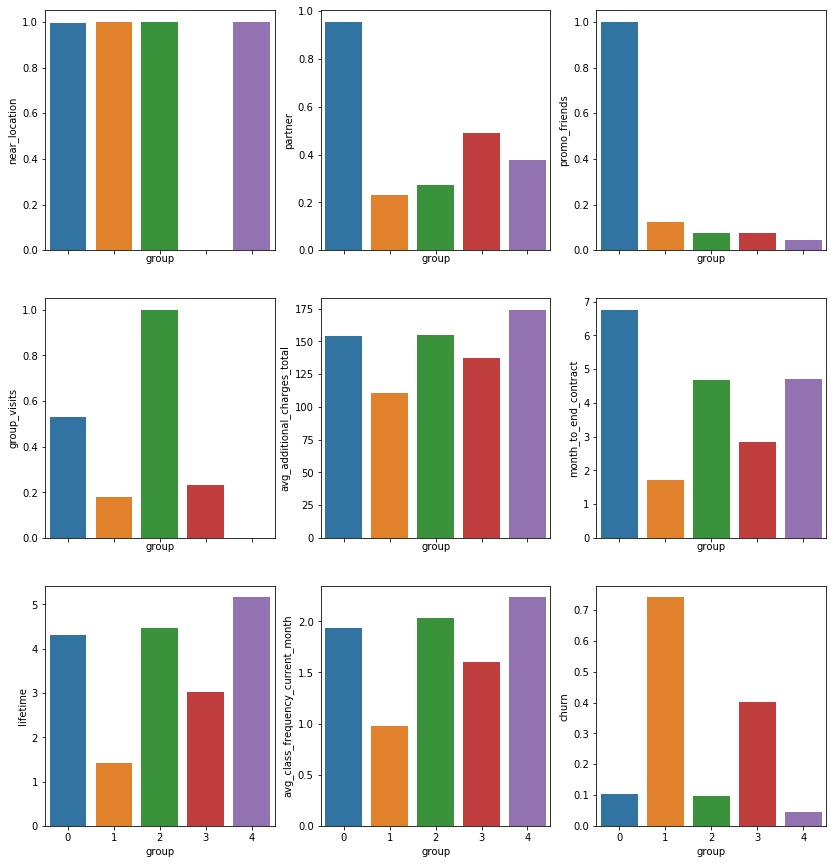

In [320]:
f, axes = plt.subplots(3, 3, figsize=(14, 15), sharex=True)
sns.barplot(x="group", y='near_location', data=groups_grouped, ax=axes[0, 0]) 
sns.barplot(x="group", y='partner', data=groups_grouped, ax=axes[0, 1]) 
sns.barplot(x="group", y='promo_friends', data=groups_grouped, ax=axes[0, 2]) 
sns.barplot(x="group", y='group_visits', data=groups_grouped, ax=axes[1, 0]) 
sns.barplot(x="group", y='avg_additional_charges_total', data=groups_grouped, ax=axes[1, 1]) 
sns.barplot(x="group", y='month_to_end_contract', data=groups_grouped, ax=axes[1, 2]) 
sns.barplot(x="group", y='lifetime', data=groups_grouped, ax=axes[2, 0]) 
sns.barplot(x="group", y='avg_class_frequency_current_month', data=groups_grouped, ax=axes[2, 1]) 
sns.barplot(x="group", y='churn', data=groups_grouped, ax=axes[2, 2]) 


Визуально оценили данные. Теперь подумаем, как машина раскидала группы и в каком порядке

Клиенты, которые живут далеко от фитнеса №3 - Это 1 шаг машины

Клиенты, которые воспользовались промо друга №0 - Это 2 шаг машины

Клиенты, которые посещают групповые занятия №2 - это 3 шаг машины

Клиенты-новички  №1 - это 4 шаг машины

Далее по остаточному принципу - клиенты которые купили длительные абонементы и давно в спортзале, предположу что это постоянные 
клиенты в группе  №4, это 5 шаг машины

Для каждого полученного кластера посчитаем долю оттока

In [321]:
data.groupby('group').agg({'churn':'mean'}).reset_index().style.background_gradient(cmap='Blues').set_precision(2)

,group,churn
0,0,0.1
1,1,0.74
2,2,0.097
3,3,0.4
4,4,0.046


Самый высоки отток однозначно у группы 1 (среднее 0,74). За ней группа 3 (среднее 0,4). Потом с большим разрывом 0 группа (0,1), затем 2 группа (0,097), затем уже 4 (0,046)

Что ж, кластеризацию провели, немного разобрали принцип кластеризации, можем теперь его еще кому то объяснить, пора переходить к выводам

## Шаг 5. Сформулируем выводы и сделаем базовые рекомендации по работе с клиентами <a id="5_id"></a>

Итак, начнем разбираться с группы который имеет самый большой отток - группа №1. Ранее предположил что это группа новичков (они с нами недавно, имеют короткий контракт. Их работодатели чаще не партнеры (соответственно доп скидок не имеют) и не посещают групповые занятия. Все просто. Придумываем им маркетинговую программу по скидкам (партнерам работодателям мы же в состоянии делать) и всячески вовлекаем в групповые занятия (клиенты, которые посещают групповые занятия имеют меньший отток).

Следующая проблемная группа - группа №3. Клиенты, которые работают и живут далеко от фитнеса. Что можно сделать. Предусмотреть для таких клиентов бесплатную парковку. Часто данные клиенты имеют скидку за счет работодателя, но не всегда. Может замотивировать скидкой для тех, кто ее не имеет. Ну и также вовлекать в групповые занятия. 

Для остальных групп тяжело дать рекомендации. Но для тех кто пришли по скидке придется поддерживать эту скидку на будущие периоды, чтобы сократить отток.